# 模型搭建通常包括以下内容：

## 1.模型选择；（确定模型框架）

## 2.模型调参优化；（确定恰当的模型超参数）

## 3.模型评估；（确定模型最终的拟合效果）

## 4.模型评分区间转化；（将模型输出值进行分值区间的映射）

## 5.模型迭代（依据实际运行结果进行周期性的迭代）


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree  
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import roc_auc_score
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

In [2]:
def auc_score_fig(clf,x,y_test):  #计算auc，三参数分别为分类器，特征与标签
    y_probs = clf.predict_proba(x)
    y_probs = y_probs[:,1]
    auc = roc_auc_score(y_test, y_probs)
    return auc

评估函数主要包含三部分：

1.AUC计算；（模型排序能力）

2.KS计算；（模型区分能力）

3.roc曲线绘制；（用于了解模型的整体质量，并可协助确定临界阈值）

3.样本基于时间稳定性的检验

In [3]:
def Model_evaluation(test_features,clf,test_target):
    #输出预测值
    y_pred = clf.predict_proba(test_features)[:,1]
        
    # 计算AUC和KS
    # KS计算
    fpr, tpr, _ = roc_curve(test_target, y_pred)
    ks = max(tpr - fpr)
    print("决策树模型最终在测试集上的KS为：",ks)

    #auc计算
    clf_auc = auc_score_fig(clf,test_features,test_target)
    print("决策树模型最终在测试集上的auc为：",clf_auc)

    # 绘制ROC曲线  
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.show()    
    
    
    # 评估不同区间，不同时间违约率，评估时间维度的稳定性（类似PSI的方式）
    y_pred = clf.predict_proba(test_features)[:,1]
    df_mid = test_features.copy()
    df_mid["years_bucket"] = pd.qcut(df_test['issueDate'], 10)
    df_mid["pred"] = y_pred
    df_mid["result"] = test_target
    df_mid["pred_bucket"] = pd.cut(df_mid['pred'], bins = [-0.1,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    print(df_mid.groupby(["years_bucket","pred_bucket"]).result.mean().head(30))

In [4]:
#读取数据
df_train = pd.read_csv(r"C:\Users\17738\贷款违约率预测\数据集\train_clean.csv")
df_test = pd.read_csv(r"C:\Users\17738\贷款违约率预测\数据集\test_clean.csv")

在训练数据中单独划分一个验证集用来评估模型的效果

In [5]:
train_data, test_data = train_test_split(df_train, test_size=0.2, random_state=1)   

In [6]:
train_data.groupby("isDefault").count()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n_der126,n_der127,n_der128,n_der129,n_der130,n_der131,n_der132,n_der133,n_der134,n_der135
isDefault,,,,,,,,,,,,,,,,,,,,,
0,512351,512351,512351,512351,512351,512351,512351,512351,512351,512351,...,512351,512351,512351,512351,512351,512351,512351,512351,512351,512351
1,127649,127649,127649,127649,127649,127649,127649,127649,127649,127649,...,127649,127649,127649,127649,127649,127649,127649,127649,127649,127649


In [7]:
test_data.groupby("isDefault").count()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n_der126,n_der127,n_der128,n_der129,n_der130,n_der131,n_der132,n_der133,n_der134,n_der135
isDefault,,,,,,,,,,,,,,,,,,,,,
0,128039,128039,128039,128039,128039,128039,128039,128039,128039,128039,...,128039,128039,128039,128039,128039,128039,128039,128039,128039,128039
1,31961,31961,31961,31961,31961,31961,31961,31961,31961,31961,...,31961,31961,31961,31961,31961,31961,31961,31961,31961,31961


In [8]:
#将特征与标签从数据集中剥离出来
train_features = train_data.drop(columns = ["isDefault"]).copy()
train_target = train_data[["isDefault"]].copy()

test_features = test_data.drop(columns = ["isDefault"]).copy()
test_target = test_data[["isDefault"]].copy()


## 模型选择；
基于模型泛化效果、可解释性考虑，初步选定以下三种模型框架进行尝试

1.具有强解释性的决策树模型

2.以bagging思想进行集成集成的随机森林模型

3.以boosting思想进行集成的xgb模型


我们将在每类探索的模型中，分别执行模型调参优化与模型评估工作

# 决策树


确定决策树的核心参数以及参数范围

In [8]:
#依据多方资料与技术交流得到的调参信息
#算力有限，此处跨度设定很粗
max_depth = [i for i in range(5,11,2)] 
min_samples_split = [i for i in range(2,100,20)] 
min_samples_leaf = [i for i in range(1,50,10)] 
max_features = [i/10 for i in range(1,10,2)] 
criterion = ["gini","entropy"]
max_leaf_nodes = [100,500,50]
class_weight = [{0:1,1:1},{0:2,1:1},{0:3,1:1},{0:4,1:1}]

将参数设定为网格搜索可使用的字典形式，因排列组合过多，可分批次进行搜索探索

In [9]:
params_state1 = {"max_depth":max_depth,"min_samples_split":min_samples_split,"min_samples_leaf":min_samples_leaf}
params_state2 = {"max_features":max_features,"criterion":criterion,"max_leaf_nodes":max_leaf_nodes}
params_state3 = {"class_weight":class_weight}

此处调参可设置不同类别的评估指标，此处以auc为例

In [ ]:
best_params = {}
clf_dt = tree.DecisionTreeClassifier()
for each in [params_state1,params_state2,params_state3]:
    clf_dt_mid = GridSearchCV(estimator=clf_dt, param_grid=each, scoring='roc_auc', cv=5,verbose=2)
    clf_dt_mid.fit(train_features,train_target)
    best_params.update(clf_dt_mid.best_params_)
    clf_dt = tree.DecisionTreeClassifier(**best_params)
#模型训练
clf_dt.fit(train_features,train_target)

In [14]:
#打印模型最优的参数与分数
# print(clf_dt.best_params_)
# print(clf_dt.best_score_)
clf_dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': {0: 1, 1: 1},
 'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 0.9,
 'max_leaf_nodes': 100,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 82,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

决策树模型最终在测试集上的KS为： 0.3025736349863007
决策树模型最终在测试集上的auc为： 0.7096640341901865


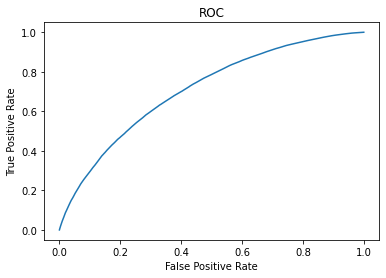

years_bucket          pred_bucket
(39261.999, 41393.0]  (-0.1, 0.1]    0.060190
                      (0.1, 0.2]     0.166222
                      (0.2, 0.3]     0.234395
                      (0.3, 0.4]     0.326255
                      (0.4, 0.5]     0.401042
                      (0.5, 0.6]     0.546512
                      (0.6, 0.7]     0.714286
                      (0.7, 0.8]          NaN
                      (0.8, 0.9]          NaN
                      (0.9, 1.0]          NaN
(41393.0, 41697.0]    (-0.1, 0.1]    0.065737
                      (0.1, 0.2]     0.151923
                      (0.2, 0.3]     0.251007
                      (0.3, 0.4]     0.356455
                      (0.4, 0.5]     0.432836
                      (0.5, 0.6]     0.488372
                      (0.6, 0.7]     0.400000
                      (0.7, 0.8]          NaN
                      (0.8, 0.9]          NaN
                      (0.9, 1.0]          NaN
(41697.0, 41911.0]    (-0.1, 0.1]    0.063918


In [244]:
#模型评估
Model_evaluation(test_features,clf,test_target)

In [15]:
#输出模型最终在测试集上的表现
clf_dt_auc = auc_score_fig(clf_dt,test_features,test_target)
print("决策树模型最终在测试集上的auc为：",clf_dt_auc)

决策树模型最终在测试集上的auc为： 0.7094674535512921


In [13]:
#模型保存
joblib.dump(clf_dt, r'C:\Users\17738\贷款违约率预测\模型存储\决策树_风控模型.pkl')

['C:\\Users\\17738\\贷款违约率预测\\模型存储\\决策树_风控模型.pkl']

# 随机森林

In [12]:
#依据多方资料与技术交流得到的调参信息
#算力有限，此处跨度设定很粗
n_estimators =[i for i in range(100,500,200)]
max_depth = [i for i in range(10,100,40)] 
min_samples_split = [i for i in range(2,20,8)] 
min_samples_leaf = [i for i in range(1,10,3)] 
max_features = [i/10 for i in range(5,10,2)] 

In [13]:
params_state1 = {"n_estimators":n_estimators,"max_depth":max_depth}
params_state2 = {"min_samples_split":min_samples_split,"min_samples_leaf":min_samples_leaf}
params_state3 = {"max_features":max_features}

In [ ]:
best_params = {}
clf_rf = RandomForestClassifier()
for each in [params_state1,params_state2,params_state3]:
    clf_rf_mid = GridSearchCV(estimator=clf_rf, param_grid=each, scoring='roc_auc', cv=5,verbose=2)
    clf_rf_mid.fit(train_features,train_target)
    best_params.update(clf_rf_mid.best_params_)
    clf_rf = RandomForestClassifier(**best_params)

In [ ]:
#模型训练
clf_rf = RandomForestClassifier(max_depth = 10, n_estimators = 300)  #算力有限，此处仅调整部分参数
clf_rf.fit(train_features,train_target)

In [34]:
clf_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

决策树模型最终在测试集上的KS为： 0.30628954612477804
决策树模型最终在测试集上的auc为： 0.7126097181797476


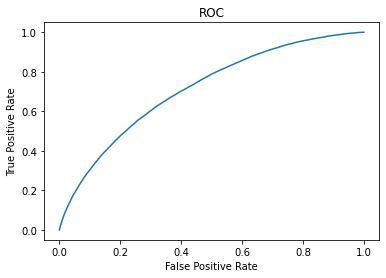

years_bucket          pred_bucket
(39261.999, 41393.0]  (-0.1, 0.1]    0.047273
                      (0.1, 0.2]     0.137453
                      (0.2, 0.3]     0.232253
                      (0.3, 0.4]     0.381890
                      (0.4, 0.5]     0.530612
                      (0.5, 0.6]     1.000000
                      (0.6, 0.7]          NaN
                      (0.7, 0.8]          NaN
                      (0.8, 0.9]          NaN
                      (0.9, 1.0]          NaN
(41393.0, 41697.0]    (-0.1, 0.1]    0.043478
                      (0.1, 0.2]     0.130112
                      (0.2, 0.3]     0.245023
                      (0.3, 0.4]     0.396825
                      (0.4, 0.5]     0.510870
                      (0.5, 0.6]     0.500000
                      (0.6, 0.7]          NaN
                      (0.7, 0.8]          NaN
                      (0.8, 0.9]          NaN
                      (0.9, 1.0]          NaN
(41697.0, 41911.0]    (-0.1, 0.1]    0.059625


In [18]:
#模型评估
Model_evaluation(test_features,clf_rf,test_target)

In [35]:
#输出模型最终在测试集上的表现
clf_rf_auc = auc_score_fig(clf_rf,test_features,test_target)
print("随机森林模型最终在测试集上的auc为：",clf_rf_auc)

决策树模型最终在测试集上的auc为： 0.7183534799913893


In [36]:
#模型保存
joblib.dump(clf_rf, r'C:\Users\17738\贷款违约率预测\模型存储\随机森林_风控模型.pkl')

['C:\\Users\\17738\\贷款违约率预测\\模型存储\\随机森林_风控模型.pkl']

# XGBOOST

In [37]:
#依据多方资料与技术交流得到的调参信息
#算力有限，此处跨度设定很粗
n_estimators_list=[i for i in range(1,121,40)]   
learning_rate_list=[i/100 for i in range(1,42,5)]  
max_depth_list=[i for i in range(3,11,4)]
max_delta_step_list=[i for i in range(1,11,4)]  
min_child_weight_list=[i for i in range(1,13,4)]
gamma_list=[i/10 for i in range(1,11,4)]
subsample_list=[i/10 for i in range(5,11,4)]
colsample_bytree_list=[i/10 for i in range(5,11,4)]
scale_pos_weight_list=[i/10 for i in range(5,42,15)]   
reg_alpha_list=[0, 0.001, 0.005, 0.01,0.05, 0.1, 1, 2, 3]
reg_lambda_list=[0, 0.001, 0.005, 0.01,0.05, 0.1, 1, 2, 3]

In [38]:
params_state1 = {'n_estimators': n_estimators_list,'learning_rate':learning_rate_list,'objective':['binary:logistic']}
params_state2 = {'scale_pos_weight': scale_pos_weight_list,'max_delta_step':max_delta_step_list}
params_state3 = {'max_depth':max_depth_list,'min_child_weight':min_child_weight_list,'gamma':gamma_list}
params_state4 = {'subsample':subsample_list,'colsample_bytree':colsample_bytree_list}
params_state5 = {'reg_alpha':reg_alpha_list,'reg_lambda':reg_lambda_list}

In [ ]:
best_params = {}
clf_xgb = XGBClassifier()
for each in [params_state1,params_state2,params_state3]:
    clf_xgb_mid = GridSearchCV(estimator=clf_xgb, param_grid=each, scoring='roc_auc', cv=5,verbose=2)
    clf_xgb_mid.fit(train_features,train_target)
    best_params.update(clf_xgb_mid.best_params_)
    clf_xgb = XGBClassifier(**best_params)
#模型训练
clf_xgb.fit(train_features,train_target)

In [42]:
#模型训练
clf_xgb = XGBClassifier()  #算力有限，此处仅展示调参代码，仍使用默认参数作为最终结果
clf_xgb.fit(train_features,train_target)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [43]:
clf_xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

决策树模型最终在测试集上的KS为： 0.3282237321487944
决策树模型最终在测试集上的auc为： 0.7257008629936672


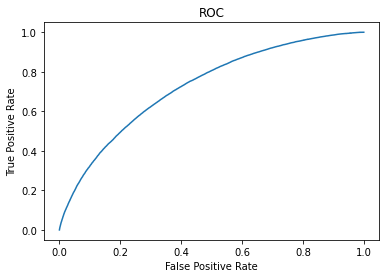

years_bucket          pred_bucket
(39261.999, 41393.0]  (-0.1, 0.1]    0.066724
                      (0.1, 0.2]     0.162470
                      (0.2, 0.3]     0.238158
                      (0.3, 0.4]     0.305804
                      (0.4, 0.5]     0.388235
                      (0.5, 0.6]     0.495868
                      (0.6, 0.7]     0.707317
                      (0.7, 0.8]     0.571429
                      (0.8, 0.9]     1.000000
                      (0.9, 1.0]          NaN
(41393.0, 41697.0]    (-0.1, 0.1]    0.069102
                      (0.1, 0.2]     0.148571
                      (0.2, 0.3]     0.267835
                      (0.3, 0.4]     0.321678
                      (0.4, 0.5]     0.408333
                      (0.5, 0.6]     0.545455
                      (0.6, 0.7]     0.465116
                      (0.7, 0.8]     0.428571
                      (0.8, 0.9]          NaN
                      (0.9, 1.0]     1.000000
(41697.0, 41911.0]    (-0.1, 0.1]    0.061990


In [22]:
#模型评估
Model_evaluation(test_features,clf_xgb,test_target)

In [44]:
#输出模型最终在测试集上的表现
clf_xgb_auc = auc_score_fig(clf_xgb,test_features,test_target)
print("XGB模型最终在测试集上的auc为：",clf_xgb_auc)

XGB模型最终在测试集上的auc为： 0.7338299478711378


In [45]:
#模型保存
joblib.dump(clf_xgb, r'C:\Users\17738\贷款违约率预测\模型存储\随XGB_风控模型.pkl')

['C:\\Users\\17738\\贷款违约率预测\\模型存储\\随XGB_风控模型.pkl']

# 模型评分区间转化
## 将输出概率转化为评分区间以便实际业务的执行

1.对数转换法

2.标准化法

3.分位数转换法

4.混合法

可以根据业务需要选择使用。此处以"对数转化法"举例

In [45]:
y_pred = clf.predict_proba(test_features)[:,1]
df_result = pd.DataFrame({'索引ID': test_features.index, '评估概率': y_pred})
df_result["索引ID"] = test_features.index
df_result["评估概率"] = y_pred
df_result["映射分数"] = df_result["评估概率"].apply(lambda x : 50 * np.log(x/(1-x))+333.5)
df_result

,索引ID,评估概率,映射分数
0,670935,0.202739,265.036756
1,649589,0.470955,327.684503
2,2028,0.163952,252.044300
3,669856,0.202585,264.989353
4,458897,0.078763,210.536609
...,...,...,...
159995,545479,0.049237,185.468803
159996,252301,0.284632,287.419935
159997,706417,0.036662,170.066281
159998,518155,0.047279,183.336851


In [44]:
df_result.describe()

,索引ID,评估概率,映射分数
count,160000.000000,160000.000000,160000.000000
mean,400093.321412,0.198037,249.512269
std,230776.855103,0.144326,51.771712
min,8.000000,0.001267,0.000856
25%,200699.500000,0.088067,216.626477
50%,400461.500000,0.161759,251.240276
75%,599736.750000,0.274011,284.781550
max,799999.000000,0.948338,478.999274


# 项目代码仅为展现本人在数据挖掘方面的技能。因时间与算力有限，当前内容仅完成模型搭建的核心环节，后期会逐步完善以下内容：

    
# 1.模型融合：

    尝试使用平均法与投票法进行模型融合；
    
# 2.调参优化：

    尝试使用随机调参与贝叶斯调参进行参数组合的探索；
    
# 3.模型部署与监控：

    补充梳理模型部署与监控的通用思路；